In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')

data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

from abm_utils import empirical_prevalence, simulate_abm, create_obs_infer
from utils_local.misc import amro2title, amro2cute


In [2]:
dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

movement_df                  = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", 'patient_movement_2022-Nov.csv'), parse_dates=['date']).drop_duplicates(subset=["date", "mrn"], keep="first")
movement_df["ward_total"]    = movement_df.apply(lambda x: x["ward"]+"-"+x["building"]+"-"+x["place"], axis=1)
movement_df                  = movement_df[movement_df["date"].isin(dates_simulation)]

mrd2id                       = {mrn: id for id, mrn in enumerate(movement_df.mrn.unique())}
ward2id                      = {ward_name: id for id, ward_name in enumerate(np.sort(movement_df.ward_total.unique()))}

movement_df["mrn_id"]        = movement_df.mrn.map(mrd2id)
movement_df["ward_id"]       = movement_df.ward_total.map(ward2id)

ward_size_df                 = movement_df.reset_index()
ward_size_df["ward_id"]      = ward_size_df["ward_total"].apply(lambda x: ward2id[x])
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df                 = ward_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
ward2size                    = {r.ward_id: r.num_patients for idx_r, r in ward_size_df.iterrows()}

id2ward                      = dict((v, k) for k, v in ward2id.items())

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}

def building2observation(building):
    if building in selected_buildings:
        return building2id[building]
    else:
        return 5

ward_names                   = np.sort(list(movement_df.ward_total.unique()))
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df["building"]    = ward_names_df["ward"].apply(lambda x: "-".join(x.split("-")[1:]))
ward_names_df["buidling_id"] = ward_names_df["building"].apply(lambda x: building2observation(x) )
ward_names_df["ward_id"]     = ward_names_df.apply(lambda x: np.where(ward_names_df.ward == x.ward)[0][0], axis=1)

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings     = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id            = {selected_buildings[i]: i for i in range(len(selected_buildings))}
wardid2buildingid      = {row.ward_id: row.buidling_id for i, row in ward_names_df.iterrows()}
movement_df["cluster"] = movement_df.ward_id.map(wardid2buildingid)

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_98167/1610801969.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])


In [3]:
gammas_search = [0.25, 0.5]
betas_search  = [0.01, 0.05, 0.1]
rho_search    = [1/100, 5/100, 10/100, 18/100]

idx_sce = 0
scenarios_large_df = pd.DataFrame(columns=["scenario", "gamma", "beta", "rho"])
for g in gammas_search:
    for b in betas_search:
        for r in rho_search:
            scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
            idx_sce += 1


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_98167/1486530046.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_98167/1486530046.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_98167/1486530046.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"

In [4]:
from models import amr_abm, observe_cluster_individual

if_settings = {
        "Nif"                : 30,          # number of iterations of the IF
        "type_cooling"       : "geometric", # type of cooling schedule
        "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
        "inflation"          : 1.01         # inflation factor for spreading the variance after the EAKF step
        }

dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")

model_settings   = {
                    "m"                 : 200,
                    "p"                 : 2,
                    "n"                 : movement_df.mrn_id.unique().shape[0],
                    "k"                 : movement_df.cluster.unique().shape[0],
                    "dates"             : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "dates_simulation"  : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "T"                 : len(dates_simulation),  # time to run
                    "num_build"         : len(np.unique(list(wardid2buildingid.values()))),
                    "k"                 : len(np.unique(list(wardid2buildingid.values())))# observing at the building aggregation
                }

assim_dates                       = list(pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun"))
assim_dates[-1]                   = dates_simulation[-1]
if_settings["assimilation_dates"] = assim_dates
id_run                            = 0


In [8]:
for idx_row, row in tqdm.tqdm(scenarios_large_df.iterrows(), total=len(scenarios_large_df)):

    path_to_save = os.path.join(results2_dir, "synthetic_inferences", "abm", "large_search", row["scenario"])
    gamma        = row["gamma"]

    path_to_samples = os.path.join(path_to_save, "infer_building", f"scenario{idx_row+1}")
    inference       = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz"))
    if os.path.isfile(os.path.join(path_to_samples,  f"{str(id_run).zfill(3)}sim_post.npz")):
        continue

    alpha = 1/120
    f0    = lambda θ:       amr_abm(t = 0,
                                                    agents_state   = np.zeros((model_settings["n"], model_settings["m"])),
                                                    gamma          = gamma,
                                                    beta           = θ[1, :],
                                                    alpha          = alpha,
                                                    movement       = movement_df[movement_df["date"]==dates_simulation[0]],
                                                    ward2size      = ward2size,
                                                    model_settings = model_settings)
    f       = lambda t, x, θ: amr_abm(t = t,
                                                    agents_state   = x,
                                                    gamma          = gamma,
                                                    beta           = θ[1, :],
                                                    alpha          = alpha,
                                                    movement       = movement_df[movement_df["date"]==dates_simulation[t]],
                                                    ward2size      = ward2size,
                                                    model_settings = model_settings)
    g = lambda t, x, θ: observe_cluster_individual(t = t,
                                                    agents_state   = x,
                                                    rho            = θ[0, :],
                                                    movement       = movement_df[movement_df["date"]==dates_simulation[t]],
                                                    model_settings = model_settings)


    θ       = inference["posterior"].mean(-2)[:, :, -1]
    y_dist  = inference["observations"]
    i_infer = inference["idx_infer"]
    y_infer = y_dist[:, :, i_infer]

    ysim = simulate_abm(f, f0, g, θ, model_settings)
    np.savez_compressed(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}sim_post.npz"),
                                    y           = ysim,
                                    y_data      = y_infer,
                                    y_dist      = y_dist,
                                    posterior   = θ,
                                    param_truth = np.array([row["rho"], row["beta"]]),
                                    gamma       = gamma,
                                    idx_infer   = i_infer)


100%|██████████| 24/24 [7:53:44<00:00, 1184.36s/it]


In [27]:
from eval.calibration import calibration
def create_sim_df(sim_samples, model_settings):
    """ Sample from the posterior simultion

    Args:
        sim_samples: Array with shape (k: num_observations, m: num_samples, T: length of simulation)
        model_settings: _description_
    """
    k, m , T = sim_samples.shape
    y = sim_samples

    sim_df = pd.DataFrame()
    for ki in range(model_settings["k"]):
        df           = pd.DataFrame(np.squeeze(y[ki, :, :]).flatten(), columns=["value"])
        df["date"]   = flatten_list([list(model_settings["dates_simulation"])] * model_settings["m"])
        df["ens_id"] = flatten_list([[mi]*model_settings["T"] for mi in range(model_settings["m"])])
        df           = df.set_index(["date", "ens_id"]).unstack([1]).resample("W-Sun").sum().stack().reset_index()
        df["yi"]     = ki
        sim_df       = pd.concat([sim_df, df])
    return sim_df

'scenario1'

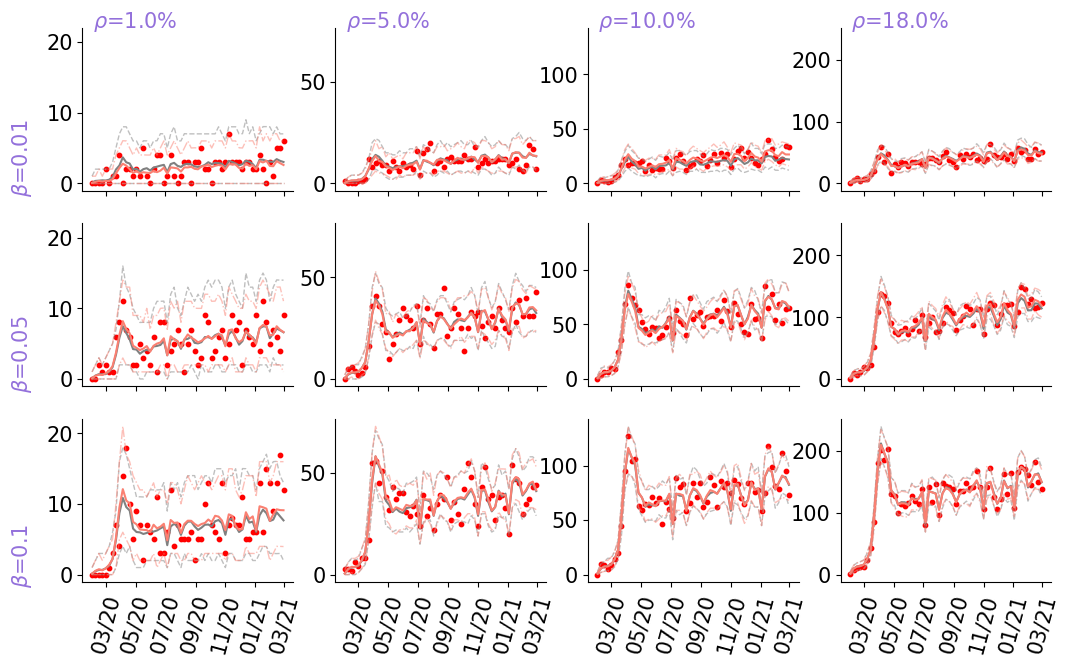

In [89]:
from matplotlib import dates as mdates
from utils import create_df_response
from utils_local import plot_utils
import matplotlib.pyplot as plt

idx_row, row = next(scenarios_large_df.iterrows())


fig, axes = plt.subplots(3, 4, figsize=(12.5, 7.2), sharex=True, sharey="col")

for id_ax, ax in enumerate(axes.flatten()):
    scenario        = scenarios_large_df.iloc[id_ax]["scenario"]

    path_to_save    = os.path.join(results2_dir, "synthetic_inferences", "abm", "large_search", scenario)
    path_to_samples = os.path.join(path_to_save, "infer_building", scenario)

    post_sim     = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}sim_post.npz"))

    obs_infer_df         = pd.DataFrame(post_sim["y_data"], columns=[f"y{i+1}" for i in range(model_settings["k"])])# at hospital level
    obs_infer_df["date"] = model_settings["dates_simulation"]
    obs_infer_df         = obs_infer_df.set_index("date").resample("W-Sun").sum()
    obs_infer_df         = pd.DataFrame(obs_infer_df.sum(1)).rename(columns={0: "value"})

    obs_all_df  = create_sim_df(post_sim["y_dist"].transpose(1, 2, 0), model_settings).groupby(["date", "ens_id"]).sum()[["value"]].unstack([1]).resample("W-Sun").sum().stack().reset_index()
    sim_df      = create_sim_df(post_sim["y"].transpose(1, 2, 0), model_settings).groupby(["date", "ens_id"]).sum()[["value"]].unstack([1]).resample("W-Sun").sum().stack().reset_index()

    hosp_samples   = sim_df.pivot(index="date", columns="ens_id", values="value").to_numpy()
    obs_truth_dist = obs_all_df.pivot(index="date", columns="ens_id", values="value").to_numpy()

    hosp_sim_df   = create_df_response(np.squeeze(hosp_samples),   time = len(if_settings["assimilation_dates"]), dates = if_settings["assimilation_dates"])
    hosp_truth_df = create_df_response(np.squeeze(obs_truth_dist), time = len(if_settings["assimilation_dates"]), dates = if_settings["assimilation_dates"])

    ax.scatter(if_settings["assimilation_dates"], obs_infer_df["value"], color="red", marker="o", s=10)

    ax.plot(if_settings["assimilation_dates"], hosp_sim_df["low_95"], color="gray", alpha=0.5, ls="--", lw=1)
    ax.plot(if_settings["assimilation_dates"], hosp_sim_df["high_95"], color="gray", alpha=0.5, ls="--", lw=1)
    ax.plot(if_settings["assimilation_dates"], hosp_sim_df["mean"], color="gray")

    ax.plot(if_settings["assimilation_dates"], hosp_truth_df["low_95"], color="salmon", alpha=0.5, ls="-.", lw=1)
    ax.plot(if_settings["assimilation_dates"], hosp_truth_df["high_95"], color="salmon", alpha=0.5, ls="-.", lw=1)
    ax.plot(if_settings["assimilation_dates"], hosp_truth_df["mean"], color="salmon")

    ax.tick_params(which='both', axis='x', labelrotation=75)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(None)
    ax.set_xlabel(None)

for i in range(4):
    axes[0, i].text(x = 18296,
                    y = axes[0, i].get_ylim()[1],
                    s = r"$\rho$={}%".format(rho_search[i] * 100),
                    color="mediumpurple")

for i in range(3):
    axes[i, 0].text(x = 18126,
                    y = axes[i, 0].get_ylim()[0],
                    s = r"$\beta$={}".format(betas_search[i]),
                    color="mediumpurple",
                    rotation=90)
